
# AAI612: Deep Learning & its Applications

*Project 2: Detecting Cyberbullying Tweets in Arabic*

<a href="https://colab.research.google.com/github/jgeitani/AAI612_Geitani/blob/main/Week8/JadGeitani_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
import matplotlib.pyplot as plt
import os

url = 'https://github.com/jgeitani/AAI612_Geitani/raw/main/Week8/cyberbullying%20datasets.xlsx'
cyberbullying_df = pd.read_excel(url)

cyberbullying_df.columns = ["text", "label"]
cyberbullying_df.dropna(subset=["text"], inplace=True)
cyberbullying_df['label'] = cyberbullying_df['label'].apply(lambda x: 1 if x == "Bullying" else 0)

In [ ]:
def error_analysis(X_test_original, y_true, y_pred, num_samples=10):
    errors = pd.DataFrame({'Tweet': X_test_original, 'True Label': y_true, 'Predicted Label': y_pred})
    misclassified = errors[errors['True Label'] != errors['Predicted Label']]

    print(f"Total misclassified examples: {misclassified.shape[0]}")
    print(f"Showing {num_samples} random misclassified examples:\n")
    print(misclassified.sample(min(num_samples, misclassified.shape[0]), random_state=42).to_string(index=False))


In [ ]:
def evaluate_and_analyze(trainer, dataset, X_texts, y_true, title):
    print(f"===== Evaluating {title} =====")
    preds = trainer.predict(dataset)
    y_pred = np.argmax(preds.predictions, axis=1)

    print(classification_report(y_true, y_pred, digits=4))

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Non-bullying', 'Bullying']).plot(cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.show()

    error_analysis(X_texts, y_true, y_pred, num_samples=10)

    return y_pred

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    cyberbullying_df['text'], cyberbullying_df['label'], test_size=0.2, stratify=cyberbullying_df['label'], random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

X_train = X_train.astype(str).tolist()
X_val = X_val.astype(str).tolist()
X_test = X_test.astype(str).tolist()

def tokenize_texts(texts):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")

train_encodings = tokenize_texts(X_train)
val_encodings = tokenize_texts(X_val)
test_encodings = tokenize_texts(X_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class ArabicCyberbullyingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
train_dataset = ArabicCyberbullyingDataset(train_encodings, y_train.tolist())
val_dataset = ArabicCyberbullyingDataset(val_encodings, y_val.tolist())
test_dataset = ArabicCyberbullyingDataset(test_encodings, y_test.tolist())

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02", num_labels=2)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    learning_rate=2e-5,
    metric_for_best_model="eval_loss",
    report_to="none",
)

trainer_arabert = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-bdd7e2a9120c>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_arabert = Trainer(


In [ ]:
os.environ["WANDB_DISABLED"] = "true"
trainer_arabert.train()

Epoch,Training Loss,Validation Loss
1,0.143600,0.114390
2,0.106300,0.104185
3,0.064200,0.128253
4,0.036500,0.143525


TrainOutput(global_step=5044, training_loss=0.0937686477219841, metrics={'train_runtime': 4223.6542, 'train_samples_per_second': 23.885, 'train_steps_per_second': 1.493, 'total_flos': 1.165387930841472e+16, 'train_loss': 0.0937686477219841, 'epoch': 4.0})

===== Evaluating AraBERT =====


              precision    recall  f1-score   support

           0     0.9788    0.9800    0.9794      2304
           1     0.7860    0.7752    0.7806       218

    accuracy                         0.9623      2522
   macro avg     0.8824    0.8776    0.8800      2522
weighted avg     0.9621    0.9623    0.9622      2522

Accuracy: 0.9623
Precision: 0.9621
Recall: 0.9623
F1-Score: 0.9622


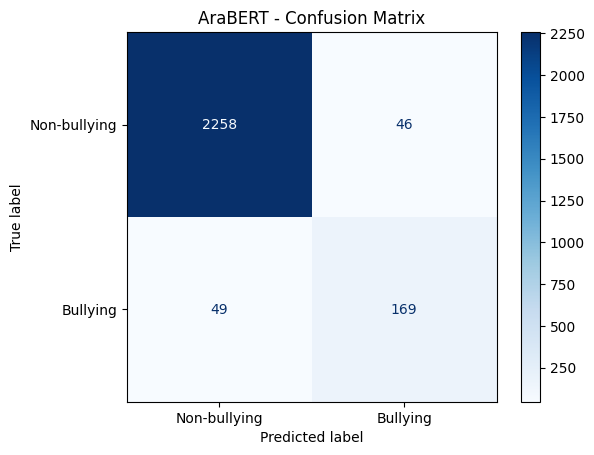

Total misclassified examples: 95
Showing 10 random misclassified examples:

                                                                                    Tweet  True Label  Predicted Label
                                                        روح ياورع يابزر روح كمل التطعيمات           0                1
                                                                         البزر ذا ما يعقل           1                0
                                                                          هاي كحبه كويتيه           1                0
                                                                      شنو خروس انا عراقية           0                1
                                                                           ويع حدك هيلكيه           1                0
                                                                                  سماجة😑😑           1                0
        كذاااااااااااااااااااااااااااااااااااااااب 👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻  

In [ ]:
y_pred_arabert = evaluate_and_analyze(trainer_arabert, test_dataset, X_test, y_test.tolist(), "AraBERT")

In [ ]:
# Freeze embedding layer and first 8 transformer encoder layers (layers 0-7)
for name, param in model.named_parameters():
    if 'embeddings' in name or any(f'encoder.layer.{i}.' in name for i in range(8)):
        param.requires_grad = False


In [ ]:
trainer_arabert.train()

Epoch,Training Loss,Validation Loss
1,0.059300,0.100607
2,0.050100,0.108234
3,0.040500,0.129997


TrainOutput(global_step=3783, training_loss=0.05008932411623417, metrics={'train_runtime': 1792.5666, 'train_samples_per_second': 56.277, 'train_steps_per_second': 3.517, 'total_flos': 8740409481311040.0, 'train_loss': 0.05008932411623417, 'epoch': 3.0})

===== Evaluating AraBERT freezing 8 =====


              precision    recall  f1-score   support

           0     0.9847    0.9748    0.9797      2304
           1     0.7593    0.8394    0.7974       218

    accuracy                         0.9631      2522
   macro avg     0.8720    0.9071    0.8886      2522
weighted avg     0.9652    0.9631    0.9640      2522

Accuracy: 0.9631
Precision: 0.9652
Recall: 0.9631
F1-Score: 0.9640


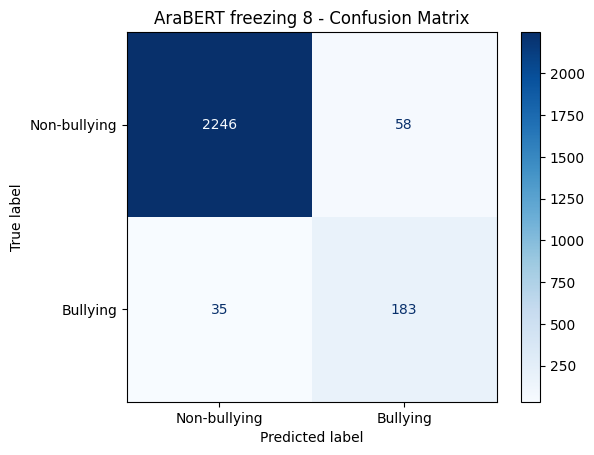

Total misclassified examples: 93
Showing 10 random misclassified examples:

                                                                                           Tweet  True Label  Predicted Label
عقول تافهة اللي تعرض مشاكلها للناس وبعدين لما يصير هجوم عليهم ولا سب وشتم يقعدون يقولون ليه وليه           0                1
                                                                           تركي العنزي انقلع انت           0                1
                                                            ابوي يسمع صوت طيط يقولي خلاص يم طقاع           0                1
                                                                             شنو خروس انا عراقية           0                1
                                 یاخی انت والله غبی یاخی رح اشتری بیتزا ب40 درهم والله انک بطران           1                0
                                            كانيا & الخاينة بزر ومتخرج من الجامعه يعرف نفسه 😂😂😂😂           0                1
                                          

In [ ]:
y_pred_arabert_freeze_8 = evaluate_and_analyze(trainer_arabert, test_dataset, X_test, y_test.tolist(), "AraBERT freezing 8")

In [ ]:
# ---- Freeze first 4 layers (0-3) ----
for name, param in model.named_parameters():
    if 'embeddings' in name or any(f'encoder.layer.{i}.' in name for i in range(4)):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [ ]:
trainer_arabert.train()

Epoch,Training Loss,Validation Loss
1,0.062700,0.122847
2,0.048000,0.144096
3,0.029900,0.161796


TrainOutput(global_step=3783, training_loss=0.04679833421497915, metrics={'train_runtime': 2445.3782, 'train_samples_per_second': 41.253, 'train_steps_per_second': 2.578, 'total_flos': 8740409481311040.0, 'train_loss': 0.04679833421497915, 'epoch': 3.0})

===== Evaluating AraBERT freezing 4 =====


              precision    recall  f1-score   support

           0     0.9801    0.9822    0.9811      2304
           1     0.8075    0.7890    0.7981       218

    accuracy                         0.9655      2522
   macro avg     0.8938    0.8856    0.8896      2522
weighted avg     0.9652    0.9655    0.9653      2522

Accuracy: 0.9655
Precision: 0.9652
Recall: 0.9655
F1-Score: 0.9653


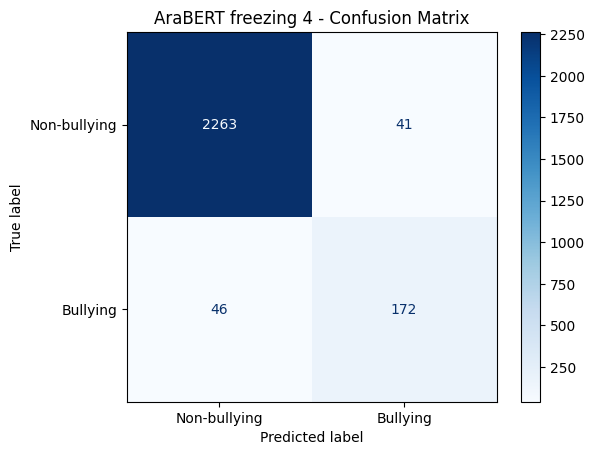

Total misclassified examples: 87
Showing 10 random misclassified examples:

                                                                                                                                                                                                                                                                                                                                                Tweet  True Label  Predicted Label
                                                                                                                                                                    استغفرالله تحطون النعمه عند رجولكم الله لايبلانا بس والله من الفسقه الله يلعن الاشكال ذي  حيوانات احمدو ربكم ان فيه النعمه هذي لعنبو هالوجيه الودره اي والله الله ياخذها من اشكال           1                0
                                                                                                                                                                                      

In [ ]:
y_pred_arabert_freeze_4 = evaluate_and_analyze(trainer_arabert, test_dataset, X_test, y_test.tolist(), "AraBERT freezing 4")

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=cyberbullying_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weight_dict = {0: class_weights[0].item(), 1: class_weights[1].item()}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.5474278330802917, 1: 5.771167278289795}


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab_size = 20000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_sequence_length)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_sequence_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_sequence_length)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn_model = Sequential([
    Embedding(max_vocab_size, 128, input_length=max_sequence_length),

    # Multiple filter sizes
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    Conv1D(filters=64, kernel_size=7, activation='relu', padding='same'),

    GlobalMaxPooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',  # Save the best model
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

cnn_history = cnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=15,
    batch_size=32,
    sample_weight=sample_weights,  # Apply sample weighting
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7253 - loss: 0.5288

631/631 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7255 - loss: 0.5287 - val_accuracy: 0.9274 - val_loss: 0.2815
Epoch 2/15
627/631 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.1483

631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9595 - loss: 0.1484 - val_accuracy: 0.9136 - val_loss: 0.2105
Epoch 3/15
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9752 - loss: 0.0802 - val_accuracy: 0.9302 - val_loss: 0.2330
Epoch 4/15
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9797 - loss: 0.0667 - val_accuracy: 0.9314 - val_loss: 0.2421
Epoch 5/15
631/631 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9838 - loss: 0.0465 - val_accuracy: 0.9481 - val_loss: 0.2399


In [ ]:
def evaluate_keras_model(model, X_test_pad, y_true, X_text_original, title="RNN"):
    preds_proba = model.predict(X_test_pad)
    y_pred = np.argmax(preds_proba, axis=1)

    print(f"===== Evaluation Report for {title} =====")
    print(classification_report(y_true, y_pred, digits=4))

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=['Non-bullying', 'Bullying']).plot(cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.show()

    error_analysis(X_text_original, y_true, y_pred, num_samples=10)

    return y_pred


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
===== Evaluation Report for CNN =====
              precision    recall  f1-score   support

           0     0.9136    1.0000    0.9548      2304
           1     0.0000    0.0000    0.0000       218

    accuracy                         0.9136      2522
   macro avg     0.4568    0.5000    0.4774      2522
weighted avg     0.8346    0.9136    0.8723      2522

Accuracy: 0.9136
Precision: 0.8346
Recall: 0.9136
F1-Score: 0.8723


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

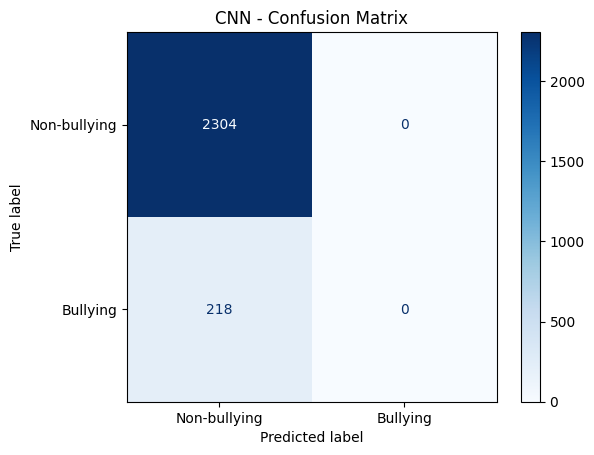

Total misclassified examples: 218
Showing 10 random misclassified examples:

                                                        Tweet  True Label  Predicted Label
               تايقر لا تستضيف هذا الدب الاحمق مر ثانية أرجوك           1                0
                                                التحدي بايخ💦💦           1                0
                    ان كانك تكذب حسبي الله عليك يا كلب الشهره           1                0
                                                      ايش قرف           1                0
  انتو ناس خيسه ولكم مو عيب حلو مشاكلكم  بعيد عن برنامج تواصل           1                0
                          ﻭﺵ ﺫﺍ ﺍﻟﻘﺮﻑ ﻗﺎﻝ ﺍﺑﻮ ﻗﺤﻂﻦ ﻗﺎﻝ ﺍﺑﻮ **           1                0
                           انت اسمك حيوان و حمار و مبذر والله           1                0
وش ده فيديو ماله طعمه عنجد شي تافه بس تحبوا تعملوا مشاكل طم✋✋           1                0
                                             انيك  أمك  وأبوك           1                0
             

In [ ]:
y_pred_cnn = evaluate_keras_model(cnn_model, X_test_seq, y_test.tolist(), X_test, title="CNN")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns


tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

rnn_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

rnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

rnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
631/631 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9122 - loss: 0.3138 - val_accuracy: 0.9132 - val_loss: 0.2976
Epoch 2/10
631/631 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9159 - loss: 0.2930 - val_accuracy: 0.9132 - val_loss: 0.2967
Epoch 3/10
631/631 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9149 - loss: 0.2947 - val_accuracy: 0.9132 - val_loss: 0.3107
Epoch 4/10
631/631 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9113 - loss: 0.3013 - val_accuracy: 0.9132 - val_loss: 0.2900
Epoch 5/10
631/631 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9144 - loss: 0.2940 - val_accuracy: 0.9116 - val_loss: 0.2963
Epoch 6/10
631/631 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9155 - loss: 0.2917 - val_accuracy: 0.9120 - val_loss: 0.3023
Epoch 7/10
631/631 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9146 - loss: 0.2942 - val_accuracy: 0.9116 - val_loss: 0.3020


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
===== Evaluation Report for RNN =====
              precision    recall  f1-score   support

           0     0.9136    1.0000    0.9548      2304
           1     0.0000    0.0000    0.0000       218

    accuracy                         0.9136      2522
   macro avg     0.4568    0.5000    0.4774      2522
weighted avg     0.8346    0.9136    0.8723      2522

Accuracy: 0.9136
Precision: 0.8346
Recall: 0.9136
F1-Score: 0.8723


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

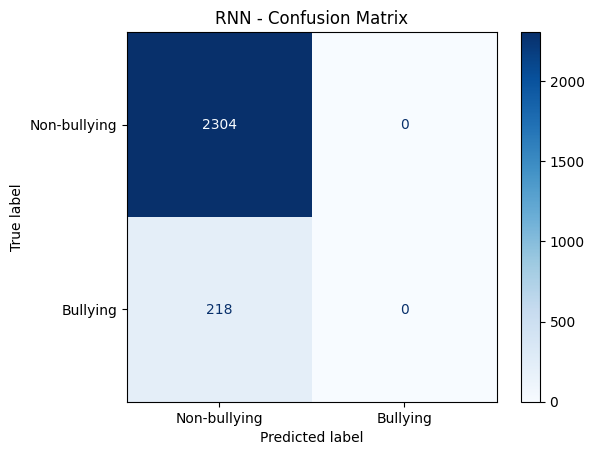

Total misclassified examples: 218
Showing 10 random misclassified examples:

                                                        Tweet  True Label  Predicted Label
               تايقر لا تستضيف هذا الدب الاحمق مر ثانية أرجوك           1                0
                                                التحدي بايخ💦💦           1                0
                    ان كانك تكذب حسبي الله عليك يا كلب الشهره           1                0
                                                      ايش قرف           1                0
  انتو ناس خيسه ولكم مو عيب حلو مشاكلكم  بعيد عن برنامج تواصل           1                0
                          ﻭﺵ ﺫﺍ ﺍﻟﻘﺮﻑ ﻗﺎﻝ ﺍﺑﻮ ﻗﺤﻂﻦ ﻗﺎﻝ ﺍﺑﻮ **           1                0
                           انت اسمك حيوان و حمار و مبذر والله           1                0
وش ده فيديو ماله طعمه عنجد شي تافه بس تحبوا تعملوا مشاكل طم✋✋           1                0
                                             انيك  أمك  وأبوك           1                0
             

In [ ]:
y_pred_rnn = evaluate_keras_model(rnn_model, X_test_pad, y_test.tolist(), X_test, title="RNN")